In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

# Repo root = dossier courant du notebook -> adapte si besoin
ROOT = Path.cwd()

DATA_DIR = ROOT / "data"
BIG_IMAGES_DIR = ROOT / "src" / "data" / "data" / "laion_aesthetic_subset_big"

# Auto-détection du meilleur CSV BIG
candidates = sorted(DATA_DIR.glob("*big*REBUILT*.csv")) + sorted(DATA_DIR.glob("*big*.csv"))
if len(candidates) == 0:
    raise FileNotFoundError(f"Aucun CSV BIG trouvé dans {DATA_DIR}. Mets ton CSV big dans le dossier data/.")

BIG_CSV = candidates[0]
print("✅ CSV utilisé :", BIG_CSV)
print("✅ Images dir :", BIG_IMAGES_DIR)


✅ CSV utilisé : C:\Debiasing-and-Improving-the-Robustness-of-CLIP-like-Models\data\laion_aesthetic_subset_metadata_big_REBUILT.csv
✅ Images dir : C:\Debiasing-and-Improving-the-Robustness-of-CLIP-like-Models\src\data\data\laion_aesthetic_subset_big


In [2]:
df = pd.read_csv(BIG_CSV)
print("✅ Dataset chargé.")
print("Shape:", df.shape)
display(df.head())
display(df.describe(include="all").T.head(20))


✅ Dataset chargé.
Shape: (200993, 8)


,image_path,caption,width,height,similarity,punsafe,pwatermark,aesthetic_score
0,src/data/data/laion_aesthetic_subset_big\00000...,Photo pour Japanese pagoda and old house in Ky...,450.0,297.0,0.345947,0.000541,0.034099,6.526204
1,src/data/data/laion_aesthetic_subset_big\00000...,Soaring by Peter Eades,675.0,900.0,0.310405,0.000006,0.076448,6.636003
2,src/data/data/laion_aesthetic_subset_big\00000...,far cry 4 concept art is the reason why it 39 ...,1600.0,754.0,0.316400,0.000043,0.496503,6.690522
3,src/data/data/laion_aesthetic_subset_big\00000...,San Pedro: One Of Mother Nature's Most Powerfu...,467.0,369.0,0.308873,0.000612,0.102705,6.749783
4,src/data/data/laion_aesthetic_subset_big\00000...,"YZV200025S © Stocktrek Images, Inc. 360 panora...",650.0,308.0,0.332100,0.000013,0.057178,6.529371


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
image_path,200993,200993,src/data/data/laion_aesthetic_subset_big\29999...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
caption,200993,171424,Russian Artist Recreates <i>Futurama</i> Skyli...,113,NaN,NaN,NaN,NaN,NaN,NaN,NaN
width,200426.0,NaN,NaN,NaN,643.42952,478.416794,83.0,360.0,500.0,760.0,9987.0
height,200632.0,NaN,NaN,NaN,562.524941,406.593373,112.0,311.0,431.0,683.0,10899.0
similarity,200438.0,NaN,NaN,NaN,0.338578,2.522249,0.0,0.307996,0.321989,0.339957,593.0
punsafe,200993.0,NaN,NaN,NaN,0.032995,0.156412,0.0,0.000002,0.000018,0.000237,0.999989
pwatermark,198901.0,NaN,NaN,NaN,0.226864,0.2069,0.0,0.087239,0.157569,0.288369,1.0
aesthetic_score,200993.0,NaN,NaN,NaN,6.637115,0.129335,6.5,6.541975,6.598834,6.692811,7.865932


In [3]:
print("Colonnes:", list(df.columns))

missing = df.isna().mean().sort_values(ascending=False) * 100
display(missing.head(30))

# Vérifier que les colonnes clés existent
expected = ["image_path", "caption"]
for c in expected:
    print(c, "->", "OK" if c in df.columns else "❌ MANQUANTE")


Colonnes: ['image_path', 'caption', 'width', 'height', 'similarity', 'punsafe', 'pwatermark', 'aesthetic_score']


pwatermark         1.040832
width              0.282099
similarity         0.276129
height             0.179608
image_path         0.000000
caption            0.000000
punsafe            0.000000
aesthetic_score    0.000000
dtype: float64

image_path -> OK
caption -> OK


In [4]:
# Adapter si tes colonnes s'appellent width/height ou WIDTH/HEIGHT etc.
w_col = "width" if "width" in df.columns else ("WIDTH" if "WIDTH" in df.columns else None)
h_col = "height" if "height" in df.columns else ("HEIGHT" if "HEIGHT" in df.columns else None)

if w_col and h_col:
    print("✅ Colonnes résolution:", w_col, h_col)
    print("Width min/median/max:", df[w_col].min(), df[w_col].median(), df[w_col].max())
    print("Height min/median/max:", df[h_col].min(), df[h_col].median(), df[h_col].max())
else:
    print("⚠️ Pas trouvé de colonnes width/height dans ce CSV.")

# Scores possibles
for score_col in ["punsafe", "pwatermark", "aesthetic_score", "AESTHETIC_SCORE", "similarity"]:
    if score_col in df.columns:
        print(f"{score_col}: min={df[score_col].min()} | median={df[score_col].median()} | max={df[score_col].max()}")


✅ Colonnes résolution: width height
Width min/median/max: 83.0 500.0 9987.0
Height min/median/max: 112.0 431.0 10899.0
punsafe: min=3.0496452585460077e-10 | median=1.801743928808719e-05 | max=0.999988853931427
pwatermark: min=0.0 | median=0.1575693786144256 | max=1.0
aesthetic_score: min=6.5 | median=6.598833560943604 | max=7.865932464599609
similarity: min=0.0 | median=0.3219889849424362 | max=593.0


Numeric cols: ['width', 'height', 'similarity', 'punsafe', 'pwatermark', 'aesthetic_score']


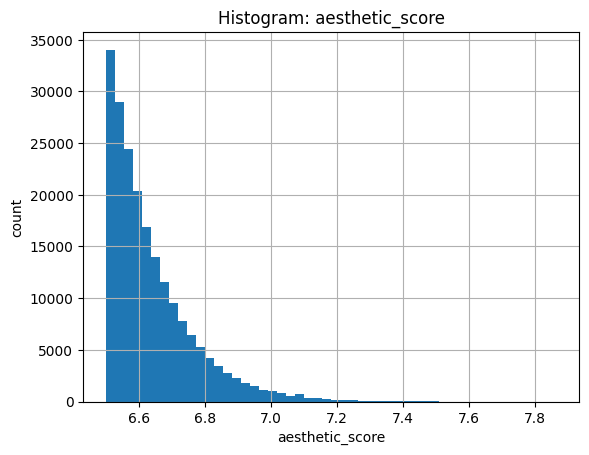

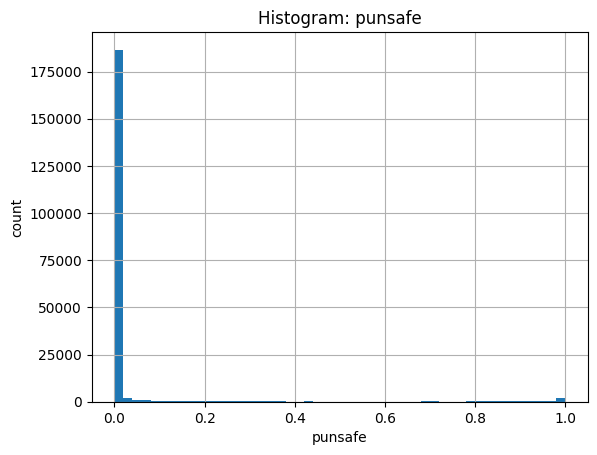

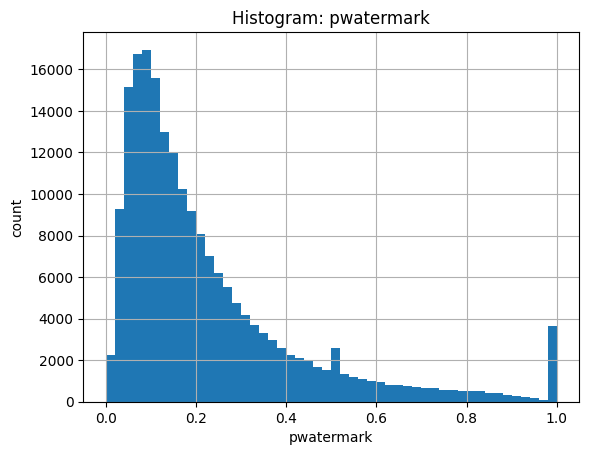

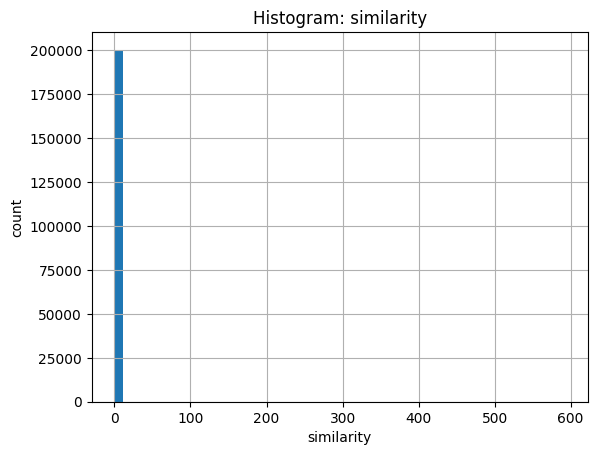

In [5]:
numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
print("Numeric cols:", numeric_cols)

for c in ["aesthetic_score", "AESTHETIC_SCORE", "punsafe", "pwatermark", "similarity"]:
    if c in df.columns:
        plt.figure()
        df[c].dropna().hist(bins=50)
        plt.title(f"Histogram: {c}")
        plt.xlabel(c)
        plt.ylabel("count")
        plt.show()


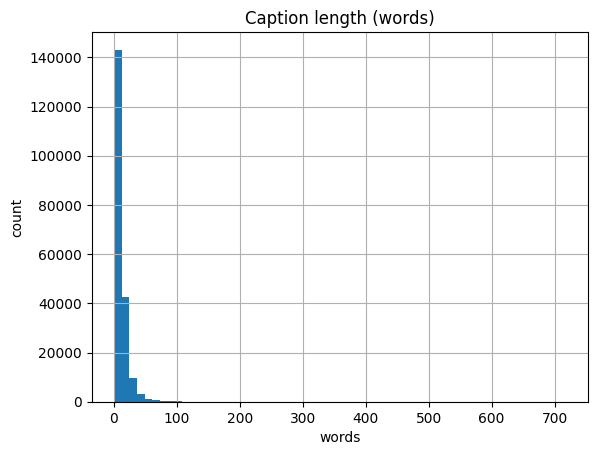

count    200993.000000
mean         11.619305
std          12.414754
min           1.000000
25%           6.000000
50%           9.000000
75%          14.000000
max         717.000000
Name: caption_len_words, dtype: float64


In [6]:
cap_col = "caption" if "caption" in df.columns else ("TEXT" if "TEXT" in df.columns else None)
if cap_col is None:
    print("❌ Pas de colonne caption/TEXT trouvée.")
else:
    df["caption_len_words"] = df[cap_col].fillna("").astype(str).apply(lambda x: len(x.split()))
    plt.figure()
    df["caption_len_words"].hist(bins=60)
    plt.title("Caption length (words)")
    plt.xlabel("words")
    plt.ylabel("count")
    plt.show()

    print(df["caption_len_words"].describe())


In [8]:
path_col = "image_path" if "image_path" in df.columns else None
if path_col is None:
    print("❌ Pas de colonne image_path dans le CSV.")
else:
    # Existence fichier
    def exists_local(p):
        if not isinstance(p, str):
            return False
        return (ROOT / p).exists() if not os.path.isabs(p) else Path(p).exists()

    df["exists"] = df[path_col].apply(exists_local)
    print("✅ % images existantes:", df["exists"].mean() * 100)
    display(df["exists"].value_counts())


✅ % images existantes: 100.0


exists
True    200993
Name: count, dtype: int64

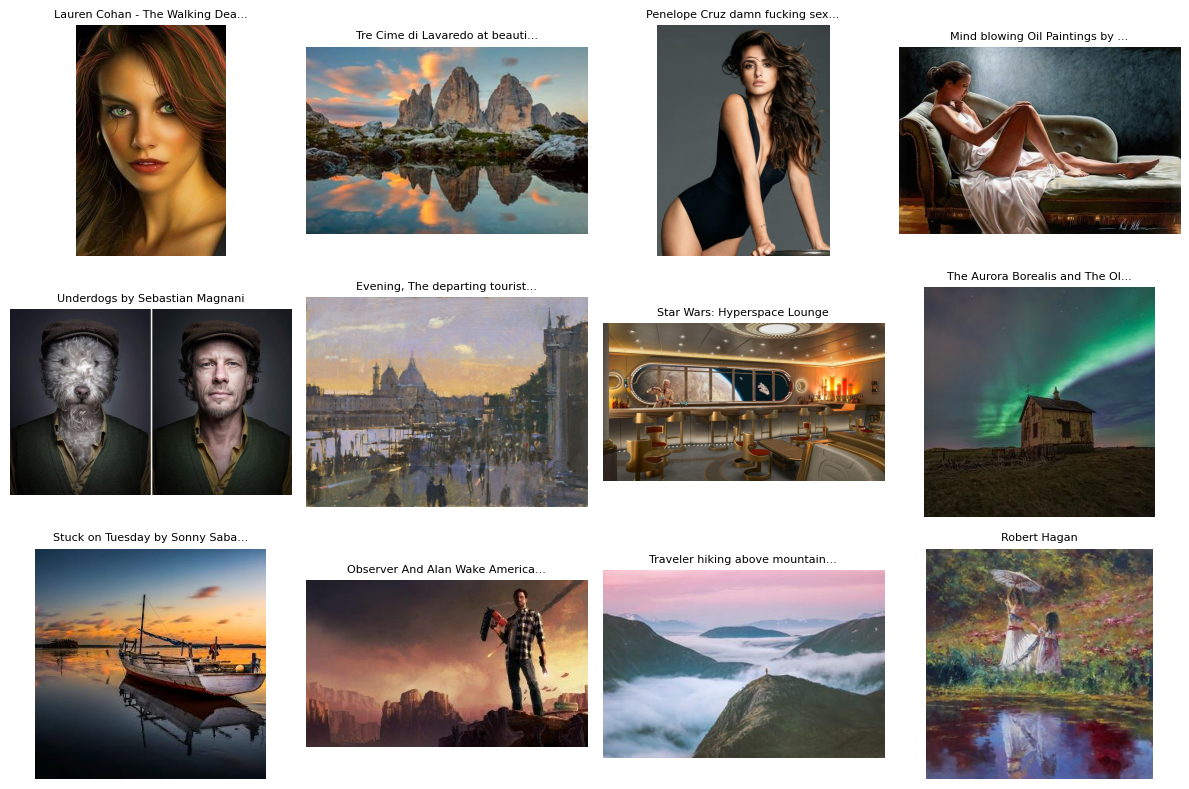

In [9]:
if "exists" in df.columns:
    sample = df[df["exists"]].sample(n=min(12, df[df["exists"]].shape[0]), random_state=42)
else:
    sample = df.sample(n=min(12, len(df)), random_state=42)

fig = plt.figure(figsize=(12, 8))
for i, (_, row) in enumerate(sample.iterrows(), start=1):
    img_path = row.get("image_path", None)
    cap = row.get("caption", row.get("TEXT", ""))

    if img_path is None:
        continue

    full_path = (ROOT / img_path) if not os.path.isabs(str(img_path)) else Path(img_path)
    ax = fig.add_subplot(3, 4, i)
    ax.axis("off")

    try:
        img = Image.open(full_path).convert("RGB")
        ax.imshow(img)
        ax.set_title(str(cap)[:30] + ("..." if len(str(cap)) > 30 else ""), fontsize=8)
    except Exception as e:
        ax.set_title("Error")
plt.tight_layout()
plt.show()
